In [1]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

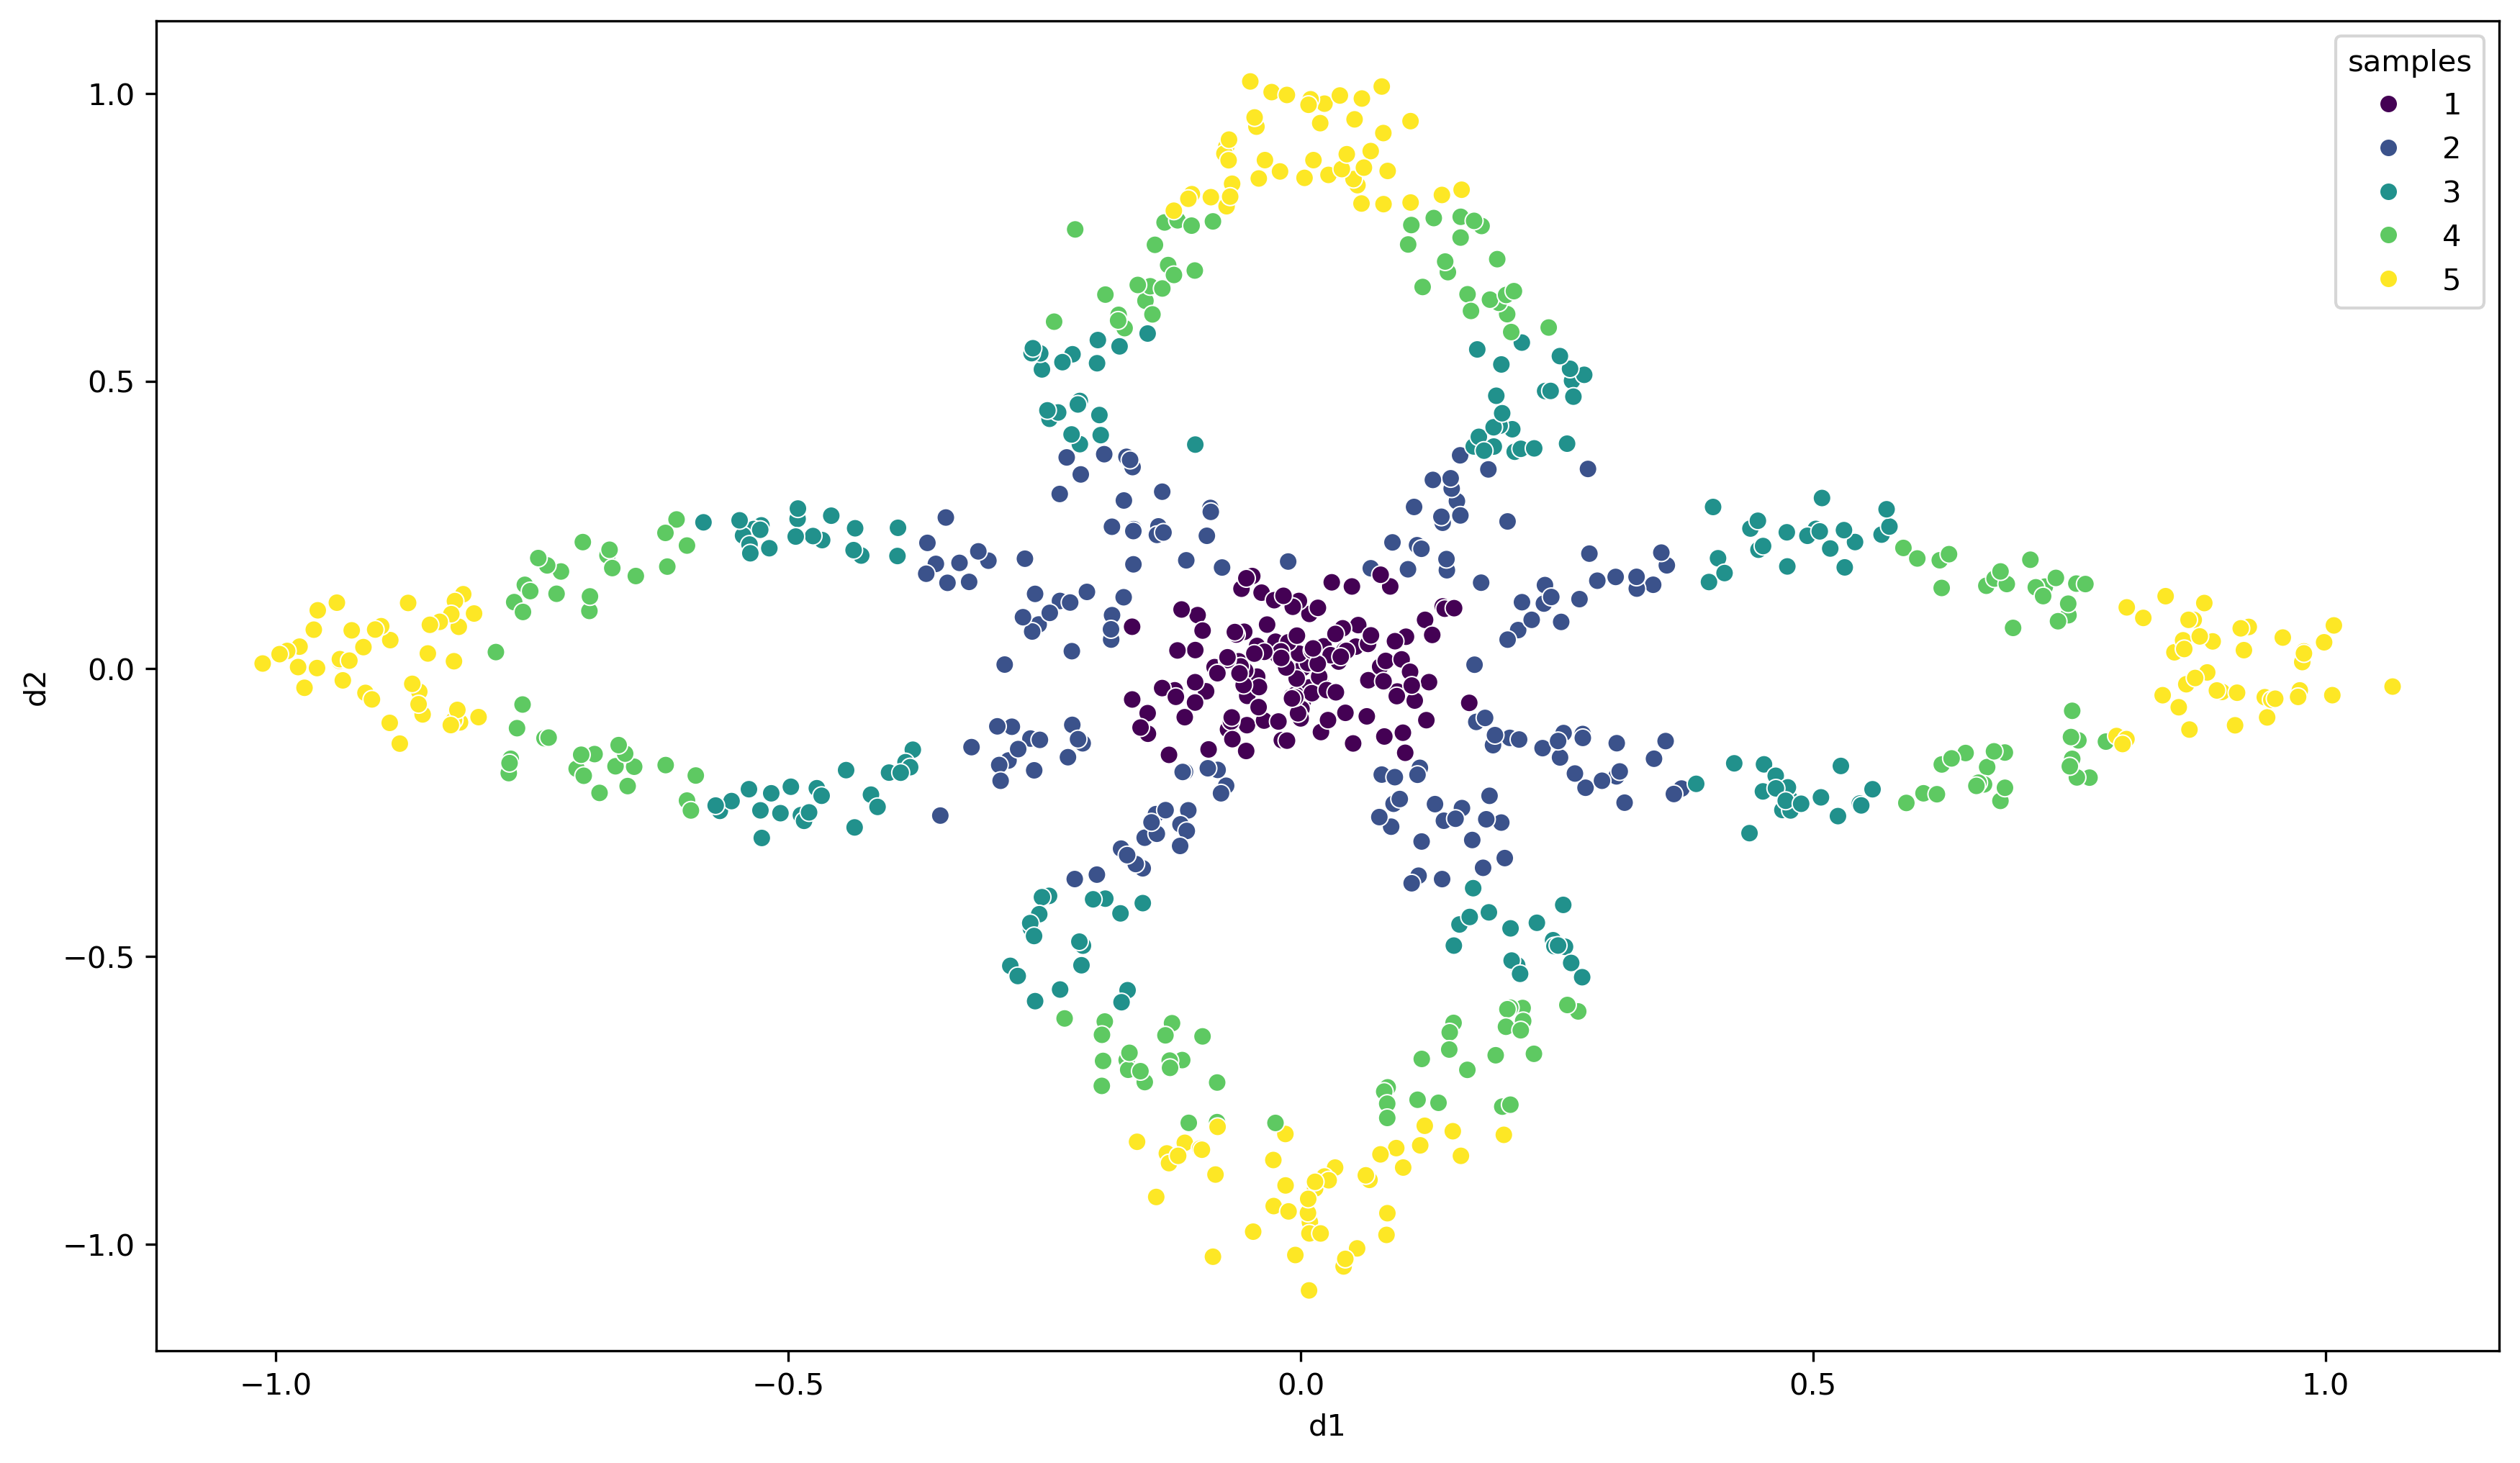

In [2]:
phate_dims = 5
df = make_diamonds()
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

In [3]:
set_seeds(0)
use_cuda = torch.cuda.is_available()
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [4]:
# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

In [5]:
# from MIOFlow.models import ConditionalModel, ConditionalODE

In [6]:
# func = ConditionalODE(model_features, 2, layers, activation=activation, scales=sde_scales)
# model = ConditionalModel(func)
model = make_model(model_features, layers, activation=activation, scales=sde_scales, use_cuda=use_cuda, n_conditions=2)

In [7]:
data_t0 = torch.tensor(df[df.samples==1][['d1','d2']].values, dtype=torch.float32)
condition = torch.tensor(df[df.samples==1][['d1', 'd2']].values, dtype=torch.float32)

In [8]:
times = torch.tensor([0, 1], dtype=torch.float32)

In [9]:
xc = torch.cat((data_t0, condition), dim=1)

In [10]:
model(xc, times).shape

torch.Size([132, 2])

In [11]:
model(xc, times, return_whole_sequence=True).shape

torch.Size([2, 132, 2])

In [12]:
model

ConditionalModel(
  (func): ConditionalODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)